In [14]:
# Automatically reload changes in python modules
%load_ext autoreload
%autoreload 2

import asyncio
from bleak import discover, BleakClient
import time
from constants import Descriptors, Commands, getCommandName
from ece4960robot import Robot
from settings import Settings
from struct import unpack, calcsize
import numpy as np

from robot_interface import *

import time
import numpy as np
import rospy
from planner_query import *
from GraphSearch import *

from commander import *

loop = asyncio.get_event_loop()
try:
    loop.run_until_complete(robotRun(loop))
except RuntimeError:
    asyncio.gather(robotRun(loop))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
theRobot = theRobotHolder.getRobot()

In [11]:
# Start points for each line segment describing the map
start_points = np.genfromtxt("StartPoints.csv", delimiter=",")
#start_points = start_points + np.array([-1,-2])

# End points for each line segment describing the map
end_points = np.genfromtxt("EndPoints.csv", delimiter=",")
#end_points = end_points + np.array([-1,-2])

# Check if map described by start_points and end_points is valid
if(not is_map_valid(start_points, end_points)):
    raise Exception("The definitions of start_points and end_points are not valid. Please make sure the number of points are equal.")

In [4]:
#resetCache() # make sure no odometry data is left over from last time
#await theRobot.setGains(0.75, 1.5, 0, 127, 1, 0)

class realRobot(BaseRobot):
    """A class to interact with the real robot
    """

    def __init__(self):
        super().__init__()
        print("Initializing Real Robot")

    async def get_pose(self):
        """Get the latest odometry pose data in the map frame.
        
        Do NOT change the arguments or return values of this function.
        
        Returns:
            (x, y, a) (float, float, float): A tuple with latest odometry pose in the map frame 
                                             in the format (x, y, a) with units (meters, meters, degrees)

        """
        await theRobot.getOdom()
        return theRobot.odomd[0:3]
    
    async def perform_observation_loop(self, observationCount=18, rotVel=30):
        """ Implement a Bluetooth command, that tells your robot to 
        start an anti-clockwise, rotational scan using PID control on 
        the gyroscope. The scan needs to be a full 360 degree rotation with 
        at least 18 readings from the TOF sensor, with the first reading taken 
        at the current heading of the robot. At the end of the scan, 
        have your robot send back the TOF measurements via Bluetooth. 
        
        If you haven't already, write an automated script to pair down your 
        measurements to 18 approximately equally spaced readings such that 
        the first reading was taken at the heading angle of the robot.
        Use a reasonable rotational speed to achieve this behavior.
        
        Do NOT change the arguments or return values of the function since it will 
        break the localization code. This function is called by the member function 
        "get_obseration_data" in the Localization class (robot_interface.py), 
        with observation_count = 18 and rot_vel = 30. 
        You may choose to ignore the values in the arguments.

        Args:
            observation_count (integer): Number of observations to record
            rot_vel (integer): Rotation speed (in degrees/s)

        Returns:
            obs_range_data (ndarray): 1D array of 'float' type containing observation range data
        """
        await theRobot.getOdom()
        odomd = theRobot.odomd
        while odomd[2] == 0:   # wait for values to come
            await asyncio.sleep(0.1)
            #print("Waiting for angle...") # for debugging
        angStart = odomd[2]
        #print(angStart) # for debugging
        odomList = []   # array of odometry readings and angles
        rTh = 30 # spin at 30°/second counterclockwise (CCW = +, CW = -)
        await theRobot.setVel(rTh,0)
        ang = 0
        while ang < 360:       # Run until the robot has made a full turn
            ang = abs(odomd[2] - angStart)   # update relative turn amount (strictly positive)
            odomList.append((ang,odomd[3]))  # save the RELATIVE angle and range to the list
            #print(ang) # for debugging
            await asyncio.sleep(0.02)
        
        await theRobot.setVel(0,0) # Stop the robot
        length = len(odomList)      # number of entries in list
        out = []                    # output list
    
        for i in range(length):     # loop through the entire list after spinning
            currAngle = round(odomList[i][0])   # current angle (integer)
            if (currAngle%20 == 0) and (currAngle/20 == len(out)-1):
                # if the angle is a multiple of 20° AND we haven't already checked it
                #out.append((currAngle,odomList[i])) # for debugging
                out.append(odomList[i][1]/1000)  # save the angle and the range IN M
            elif currAngle/20 > (len(out)): # if we skipped one
                j = i
                angleJ = round(odomList[j][0])
                while angleJ < (len(out)+1):
                    j = j - 1                # average two closest angles
                    angleJ = abs(round(odomList[j][0]))
                r = 0.5*odomList[i][1]+0.5*odomList[j][1]
                th = 0.5*currAngle + 0.5*angleJ
                #out.append((th,r)) # debugging
                out.append(r/1000) # /1000 since measurements are in mm and we
        if len(out)==0:
            print("Warning: got zero observation readings.")
        else:
            out.insert(0, out.pop(-1))
        return np.array(out)
    
    async def set_vel(self, v, w):
        """Set a linear and an angular velocity for your robot.
        
        You will use this function to move the robot.
        It is not used by the Localization class and so you
        may change the arguments and/or return types as needed.

        Args:
            v (integer): Linear velocity
            w (integer): Angular velocity
        """
        await theRobot.setVel(v,w)
        
    def get_gt_pose(self):
        # Do not change this function
        """Get the latest ground truth pose data
        
        Do NOT change the arguments or return values of this function.

        Returns:
            (x, y, a) (float, float, float): A tuple with latest ground truth pose 
                                             in the format (x, y, a) with units (meters, meters, degress)

        """
        # Since there is no mechanism to find out the ground truth pose of your real robot,
        # it simply returns the odometry pose.
        # This function exists to comply with the design model of the Localization class
        return self.get_pose()

In [5]:
# Instantiate RealRobot to communicate with the real robot
robot = realRobot()

# Instantiate Mapper
# Requires a RealRobot object as input
minX = -0.4
maxX = 2
minY = -0.3
maxY = 5
cellsX = round((maxX - minX)/0.2)
cellsY = round((maxY - minY)/0.2)
cellsA = 18 # fixed: +/-180° in 20° increments
mapper = Mapper(min_x=minX, max_x=maxX, min_y=minY, max_y=maxY, min_a=-180, max_a=180,
                cell_size_x=0.2, cell_size_y=0.2, cell_size_a=20,
                max_cells_x=cellsX, max_cells_y=cellsY, max_cells_a=18,
                ray_length=8, lines=[start_points, end_points], obs_per_cell=18, 
                robot=robot)

# Instantiate Localization
odom_trans_sigma = 0.33
odom_rot_sigma = 15
sensor_sigma = 0.11

# Requires a RealRobot object and a Mapper object as inputs
loc = Localization(robot, mapper, sensor_sigma, odom_trans_sigma, odom_rot_sigma)

# Visualize the map (described using line segments) in the plotter
#loc.plotter.visualize_map()

# Peform raycasting and pre-cache the values
mapper.populate_views()

Using python version: 3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0] 

Initializing Node
Initializing Real Robot
Initializing beliefs with a Uniform Distribution
Uniform Belief with each cell value:  0.00017806267806267807
 | Precaching Views...
 | Precaching Time:  15.25425672531128


In [18]:
await asyncio.sleep(5)
await theRobot.setVel(0,100)
await asyncio.sleep(2)
await theRobot.setVel(0,0)

In [17]:
# angular test
speed = 100
turnAngle = 90
sign = 1
stopTime = 0.5
loopTime = 0.1
angThreshold = 2

await asyncio.sleep(5)
await theRobot.getOdom()
while theRobot.odomd[3] is 0:
    await asyncio.sleep(loopTime)
startAngle = theRobot.odomd[2]
for i in range(2):
    error = turnAngle - (theRobot.odomd[2] - startAngle)
    if turnAngle > 0:
        # need to turn CCW
        await theRobot.setVel(0,0) # stop first
        await asyncio.sleep(stopTime)
        while error > angThreshold: # run proportional control
            error = turnAngle - (theRobot.odomd[2] - startAngle)
            #print("Heading error is " + str(error)+"°\n")
            #print("Angle is " + str(theRobot.odomd[2])+"°\n")
            await theRobot.setVel(0,max(30,2*error)) # with threshold
            await asyncio.sleep(loopTime)
    elif turnAngle < 0:
        # need to turn CW
        await theRobot.setVel(0,0)
        await asyncio.sleep(stopTime)
        while -error > angThreshold: # run proportional control
            error = turnAngle - (theRobot.odomd[2] - startAngle)
            print("Heading error is " + str(error)+"°\n")
            print("Angle is " + str(theRobot.odomd[2])+"°\n")
            await theRobot.setVel(0,min(-30,2*error)) # with threshold
            await asyncio.sleep(loopTime)
    await robot.set_vel(0,0)
    await asyncio.sleep(stopTime)

CancelledError: 

In [34]:
expectedView = 0.3 # meters from wall
drivingForward = True
linearThreshold = 0.01

currentView = theRobot.odomd[3]/1000 # ToF reading (m)
print("When I get there, I will see " + str(expectedView)+" m\n")
print("Now, I see " + str(currentView)+" m\n")
error = currentView - expectedView
if currentView < expectedView: # need to drive backwards
    if drivingForward: # need to reverse direction
        await theRobot.setVel(0,0) # stop first
        await asyncio.sleep(stopTime)
    while -error > linearThreshold:
        print("Position error is " + str(error)+" m\n")
        vel = min(max(error,-1),-0.2)
        # don't go past 100% or below 20%                    
        await theRobot.setVel(vel,0)
        await asyncio.sleep(loopTime)
        error = theRobot.odomd[3]/1000 - expectedView # update reading
    drivingForward = False
else: # currentView >= expectedView; need to drive forwards
    if not drivingForward: # need to reverse direction
        await theRobot.setVel(0,0) # stop first
        await asyncio.sleep(stopTime)
    while error > linearThreshold:
        print("Position error is " + str(error)+" m\n")
        vel = max(min(error,1),0.2)
        # don't go past 100% or below 20%
        await theRobot.setVel(vel,0)
        await asyncio.sleep(loopTime)
        error = theRobot.odomd[3]/1000 - expectedView # update reading
    drivingForward = True
await theRobot.setVel(0,0)

When I get there, I will see 0.3 m

Now, I see 1.907 m

Position error is 1.607 m

Position error is 1.607 m

Position error is 1.6059999999999999 m

Position error is 1.567 m

Position error is 1.566 m

Position error is 1.568 m

Position error is 1.577 m

Position error is 1.57 m

Position error is 1.571 m

Position error is 1.575 m

Position error is 1.573 m

Position error is 1.566 m

Position error is 1.57 m

Position error is 1.5779999999999998 m

Position error is 1.569 m

Position error is 1.575 m

Position error is 1.574 m

Position error is 1.571 m

Position error is 1.574 m

Position error is 1.57 m

Position error is 1.573 m

Position error is 1.57 m

Position error is 1.574 m

Position error is 1.57 m

Position error is 1.571 m

Position error is 1.571 m

Position error is 1.571 m

Position error is 1.571 m

Position error is 1.573 m

Position error is 1.569 m

Position error is 1.571 m

Position error is 1.57 m

Position error is 1.575 m

Position error is 1.577 m

Positi

CancelledError: 

In [17]:
await theRobot.getOdom()

In [31]:
# gain change test
await theRobot.setGains(0.75,1.5,0,-5,0.95,-5)

## class PlannerQuery
A class to generate random start and goal cells given an occupancy grid. <br>
It requires an argument <span style="color:rgb(100,191,100)">grid</span>, which is a 2D binary numpy matrix representing the occupancy grid. Refer to the lab10 documentation for more info.

### Member Functions:
- <span style="color:rgb(255,191,0)">**generate()**</span>:  Returns a random start and goal cell. Set the argument **plot** to *True* if you want to visualize the start and goal cell in the grid map.

Start cell:  (14, 5)
Goal cell:  (4, 1)


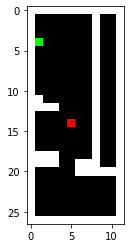

Found a solution after 0.060 seconds

-----------------


In [11]:
# Generate a grid of the right size; all unoccupied cells are zero...
grid = np.zeros((cellsY+1, cellsX), dtype=np.uint8) # planner needs 8-bit integers
# (maybe it's my choice of bounding box, but the y dimension gets chopped off, so it needs 1 more.)
# ... and the the occupied cells are 1
# (negative numbers tend to mess this up. So, the code shifts the coordinates until they are positive.)
minX = min(start_points[:,0]) # and note that the two arrays contain all the same points,
minY = min(start_points[:,1]) # just in different orders
for i in range(np.shape(start_points)[0]):
    xStart = start_points[i,0] - minX
    yStart = start_points[i,1] - minY
    xEnd = end_points[i,0] - minX
    yEnd = end_points[i,1] - minY
    # interpolate with half-cell resolution so no cells are skipped
    numInterpPoints = round(max(abs((xEnd-xStart)/0.1), abs((yEnd-yStart)/0.1)))
    #print(numInterpPoints)
    if (numInterpPoints > 0): # sometimes there will be a duplicate point
        stepX = (xEnd-xStart)/numInterpPoints
        stepY = (yEnd-yStart)/numInterpPoints
        #print("step: {},{}".format(stepX, stepY))
        for s in range(numInterpPoints):
            x = s*stepX + xStart
            y = s*stepY + yStart
            #print("{},{}".format(x,y))
            grid[int(y/0.2),int(x/0.2)] = 1
    else:
        grid[int(yStart/0.2),int(xStart/0.2)] = 1
grid = np.flipud(grid) # by default, rows are numbered top-to-bottom

# Instantiate the class PlannerQuery
pq = PlannerQuery(grid)

searcher = search(grid)
solution = []

# Generate 10 different start and goal cells based on the occupancy grid encoded in the **grid** variable. 
# Each plot showcases the obstacles in white, while the start and goals cells are depicted in red and green, respectively.
numStartGoal = 1 # will be 10 eventually
for i in range(0,numStartGoal):
    # Generate a start and goal pair
    x = pq.generate(plot=True)
    solution.append(searcher.astar(x[0], x[1]))
    print("-----------------")

In [19]:
# Actually run the thing
stopTime = 0.5 # time (s) to wait for the robot to come to a full stop
loopTime = 0.1 # time (s) to wait during while loops
drivingForward = True # bit to remember which way we've been driving
linearThreshold = 0.1 # allowed deviation in linear positioning
angThreshold = 2 # allowed deviation in angular positioning

for i in range(0,numStartGoal):
    if solution[i] is not None:
        await asyncio.sleep(0.1) # put "await anything" here and IPython pukes
        await theRobot.getOdom() # request odometry and ToF data
        sLast = [*x[0],0] # initialize "last" position at starting point (0° heading)
        while theRobot.odomd[3] is 0:
            await asyncio.sleep(loopTime) # wait for ToF readings to show up
        for s in solution[i]:
            print("Step " + str(solution[i].index(s)) + ":\n")
            print(s)
            # THESE ARE INDICES and not world coordinates
            pose = [s[1],s[0],round((9/2)*s[2]+9)] # 90° to 20° increments
            if pose[2] > 18: # normalize the angle index
                pose[2] = pose[2] - 18
            elif pose[2] < 0:
                pose[2] = pose[2] + 18
            print("I'm about to go to pose " + str(pose))
            expectedView = loc.mapper.get_views(*pose)[0] # view facing forward, m
            print("When I get there, I will see " + str(expectedView)+" m\n")
            # use 90° increments so 0° doesn't turn into +/- 10°
            turnAngle = 90*(s[2] - sLast[2])
            if turnAngle > 180: # normalize the turn angle
                turnAngle = turnAngle - 360
            elif turnAngle < -180:
                turnAngle = turnAngle + 360
            print("I need to turn " + str(turnAngle)+"°\n")
            startAngle = theRobot.odomd[2]
            error = turnAngle - (theRobot.odomd[2] - startAngle)
            if turnAngle > 0:
                # need to turn CCW
                await theRobot.setVel(0,0) # stop first
                await asyncio.sleep(stopTime)
                while error > angThreshold: # run proportional control
                    error = turnAngle - (theRobot.odomd[2] - startAngle)
                    print("Heading error is " + str(error)+"°\n")
                    print("Angle is " + str(theRobot.odomd[2])+"°\n")
                    await theRobot.setVel(0,max(30,2*error)) # with threshold
                    await asyncio.sleep(loopTime)
            elif turnAngle < 0:
                # need to turn CW
                await theRobot.setVel(0,0)
                await asyncio.sleep(stopTime)
                while -error > angThreshold: # run proportional control
                    error = turnAngle - (theRobot.odomd[2] - startAngle)
                    print("Heading error is " + str(error)+"°\n")
                    print("Angle is " + str(theRobot.odomd[2])+"°\n")
                    await theRobot.setVel(0,min(-30,2*error)) # with threshold
                    await asyncio.sleep(loopTime)
            await robot.set_vel(0,0)
            await asyncio.sleep(stopTime)
            else: # need to drive straight, not turn
                currentView = theRobot.odomd[3]/1000 # ToF reading (m)
                print("When I get there, I will see " + str(expectedView)+" m\n")
                print("Now, I see " + str(currentView)+" m\n")
                error = currentView - expectedView
                if currentView < expectedView: # need to drive backwards
                    if drivingForward: # need to reverse direction
                        await theRobot.setVel(0,0) # stop first
                        await asyncio.sleep(stopTime)
                    while -error > linearThreshold:
                        print("Position error is " + str(error)+" m\n")
                        vel = min(max(error,-1),-0.2)
                        # don't go past 100% or below 20%                    
                        await theRobot.setVel(vel,0)
                        await asyncio.sleep(loopTime)
                        error = theRobot.odomd[3]/1000 - expectedView # update reading
                    drivingForward = False
                else: # currentView >= expectedView; need to drive forwards
                    if not drivingForward: # need to reverse direction
                        await theRobot.setVel(0,0) # stop first
                        await asyncio.sleep(stopTime)
                    while error > linearThreshold:
                        print("Position error is " + str(error)+" m\n")
                        vel = max(min(error,1),0.3)
                        # don't go past 100% or below 30%
                        await theRobot.setVel(vel,0)
                        await asyncio.sleep(loopTime)
                        error = theRobot.odomd[3]/1000 - expectedView # update reading
                    drivingForward = True
            sLast = s

    #         # x's are columns and y's are rows, backwards but right-side-up
    #         xWorld = list(loc.mapper.from_map(*s)[:2])
    #         xWorld.reverse()        
    #         xWorld[0] = minX + xWorld[0]
    #         xWorld[1] = maxY + minY - xWorld[1]
    #         loc.plotter.plot_point(*xWorld,ODOM)
    #     xWorld = [] # initialize world coordinate array
    #     for k in range(2): # get x,y coords. of start and end points
    #         xWorld.append(list(loc.mapper.from_map(*x[k],0))[:2])
    #         xWorld[k].reverse()
    #         xWorld[k][0] = minX + xWorld[k][0]
    #         xWorld[k][1] = maxY + minY - xWorld[k][1]
    #     loc.plotter.plot_point(*xWorld[0],BEL)
    #     loc.plotter.plot_point(*xWorld[1],GT)

SyntaxError: invalid syntax (<ipython-input-19-74c21dd565cb>, line 10)

In [40]:
await theRobot.setVel(0,0)

In [ ]:
#  Reset the plot, initializes the belief with a uniform distribution, 
# performs the rotation behaviour, and runs the update step
def init_bayes_filter():
    # Reset Plots
    loc.plotter.reset_plot()

    # Initiize belief
    loc.init_uniform_distribution()

    # Get Observation Data by executing a 360 degree rotation motion
    loc.get_observation_data()

    # Update Step
    loc.update_step()
    loc.print_update_stats(plot_data=True)

# One iteration of the Bayes filter algorithm
def step_bayes_filter(current_odom, prev_odom):
    # Prediction Step
    loc.prediction_step(current_odom, prev_odom)
    loc.print_prediction_stats(plot_data=True)

    # Get Observation Data by executing a 360 degree rotation behavior
    loc.get_observation_data()

    # Update Step
    loc.update_step()
    loc.print_update_stats(plot_data=True)
    

# Records the odom before a robot motion, 
# moves the robot, and records the odom again after motion
async def move_robot(linSpeed, angSpeed, t):
    '''Inputs:  linSpeed (float): linear velocity target; 0 for point turn
                angSpeed (float): angular velocity target; 0 for straight line
                t (float): time to move at this speed
        Outputs: curr_odom (float tuple): x, y, and theta after moving
                prev_odom (float tuple): x, y, and theta before moving
    '''
    prev_odom = await robot.get_pose()

    # Code to move your robot goes here
    await robot.setVel(linSpeed,angSpeed)
    time.sleep(t)
    await robot.setVel(0,0)
    # the move function both moves the robot and outputs the pose
    curr_odom = await robot.get_pose()
    
    return curr_odom, prev_odom


In [ ]:
#steps = [[1,0,2]] # one step: drive straight and stop
steps = []        # just run one update step
init_bayes_filter()
for i in range(len(steps)):
    [currOdom, prevOdom] = move_robot(*steps[i])
    step_bayes_filter(currOdom, prevOdom)


In [13]:
theRobot.quitBT()